### Look for the best tracking parameters on a smaller video

This step should be done prior to doing the tracking on the entire video. 

Import a smaller number of frames (I would saround 100) of the background subtracted video and the original video to look for the best tracking parameters: pixel number, minmass, threshold, separation, search range and memory. 

This code also gives as output the tracked trajectories plotted on the original video frames and save them in a folder provided by the user.

Written by Medea Zanoli 30/12/2021


In [1]:
from PIL import Image, ImageEnhance, ImageSequence, ImageOps,  ImageChops, ImageFilter,  ImageDraw

from tkinter import Tk
from tkinter.filedialog import askdirectory, askopenfilename

import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np

from progressbar import ProgressBar
import progressbar

import pandas as pd
import cv2 

import seaborn as sns

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

from matplotlib import path

import pickle
import pims
import trackpy as tp

IMPORT THE BACKGROUND SUBSTRACTED VIDEO. Select the file manually

In [3]:
# background substracted video
video_file = askopenfilename()
video = pims.as_grey(pims.Video(video_file))

bw_cap= cv2.VideoCapture(video_file)

bar = ProgressBar(max_value=progressbar.UnknownLength)
i=0
bw_frame_list = []

while(bw_cap.isOpened()):
    ret, frame = bw_cap.read()
    if ret == False:
        break
    bw_frame_list.append(frame)
    i+=1

    bar.update(i)

/ |       #                                         | 848 Elapsed Time: 0:00:09

In [4]:
#  IMPORT THE ORIGINAL VIDEO IN COLORS 

# color video
video_name = askopenfilename()
cap= cv2.VideoCapture(video_name)

bar = ProgressBar(max_value=progressbar.UnknownLength)
i=0
frame_list = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    frame_list.append(frame)
    i+=1
    bar.update(i)
    
colored_video = pims.Video(video_name)


/ |#                                                  | 0 Elapsed Time: 0:00:00

### Choose the pixel number

In [5]:
pixel_number = 9 # diameter: features extent. Must be an be odd integer. When in doubt, round up.
                    #If we use a pixel number too high then it groups together cells that are too close to each other. 

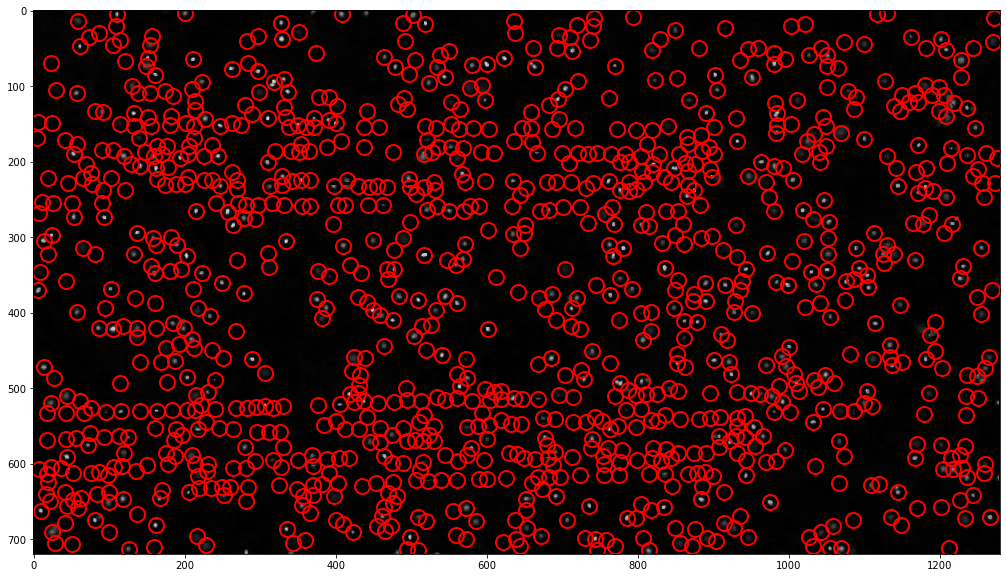

In [6]:
## see if it works. Change frame number to check the performance on different frames
frame = 10
f = tp.locate(video[frame], 
              diameter = pixel_number, 
              )  # threshold=threshold, separation=separation, minmass = minmass

plt.figure(figsize = (18,10))
tp.annotate(f, bw_frame_list[frame]);

### Choose the minmass parameter

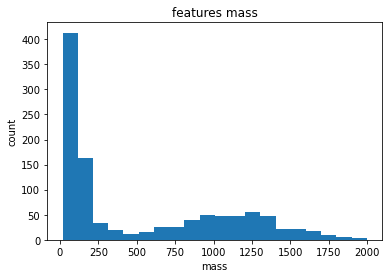

In [18]:
# plot the histogram of the features mass to decide the minmass parameter

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count')
ax.set_title('features mass');

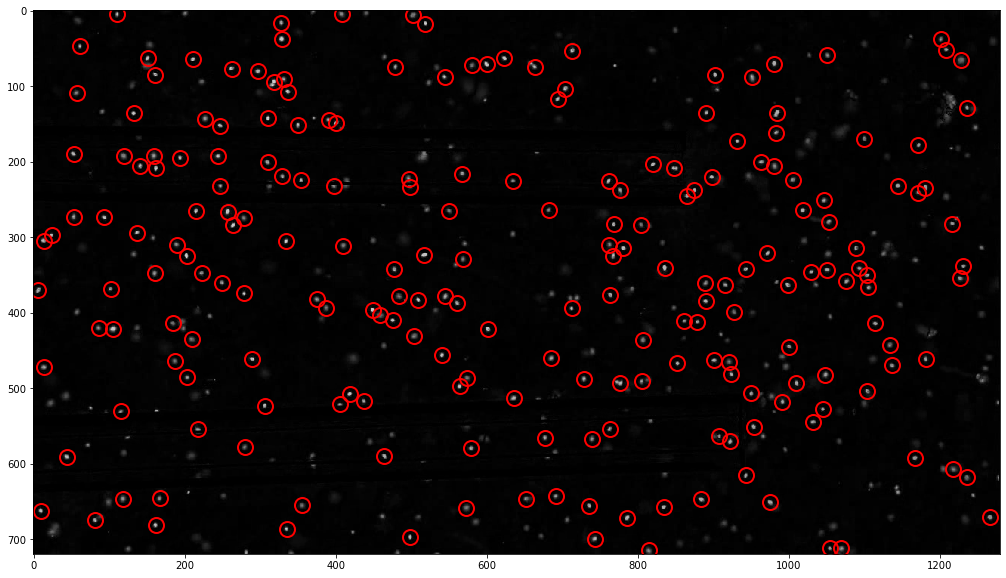

In [7]:
minmass = 1000 

f = tp.locate(video[frame], 
              diameter = pixel_number,
              minmass=minmass)  # threshold=threshold, separation=separation, minmass = minmass

plt.figure(figsize = (18,10))
tp.annotate(f, bw_frame_list[frame]);

### Choose the threshold parameter

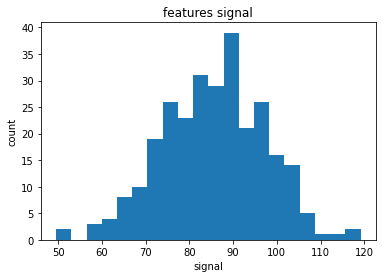

In [20]:
# plot the histogram of the features mass to decide the threshold 

fig, ax = plt.subplots()
ax.hist(f['signal'], bins=20)
ax.set(xlabel='signal', ylabel='count')
ax.set_title('features signal');

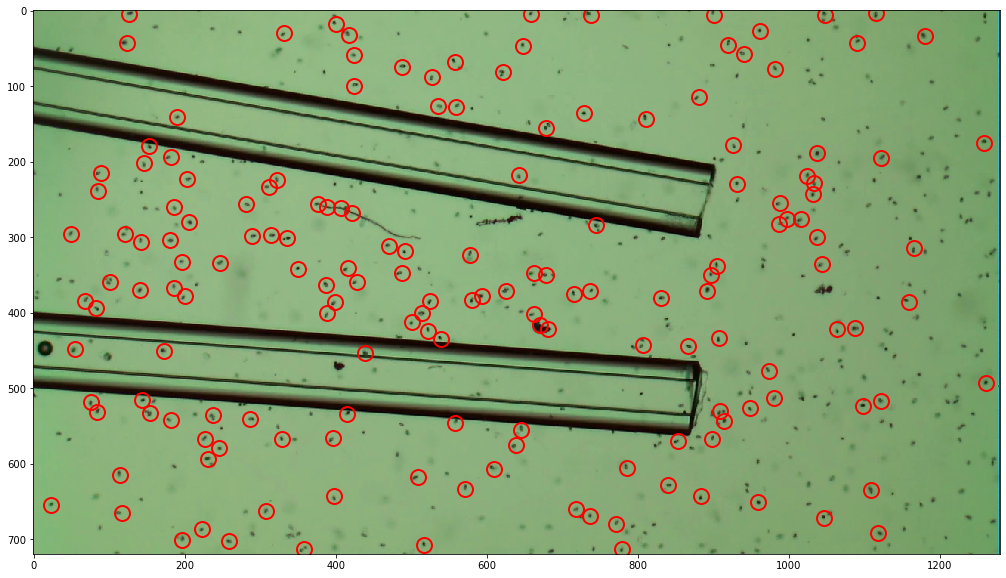

In [23]:
threshold = 30#20 # Clip bandpass result below this value (correspond to the parameter "signal")

f = tp.locate(video[frame], 
              diameter = pixel_number,
              minmass=minmass, 
             threshold=threshold)  # threshold=threshold, separation=separation, minmass = minmass

plt.figure(figsize = (18,10))
tp.annotate(f, frame_list[frame]);

### Choose the separation parameter

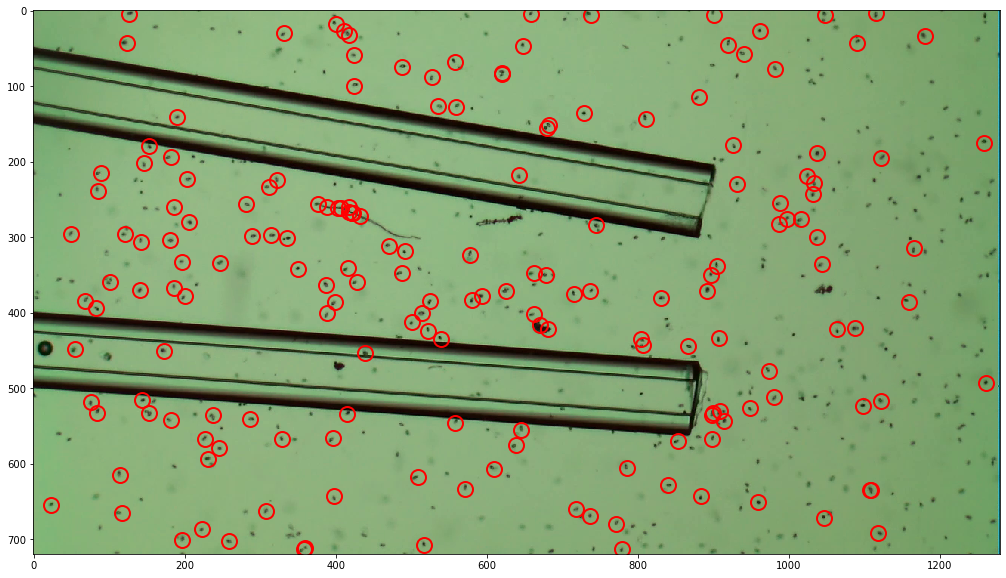

In [25]:
separation = 1

f = tp.locate(video[frame], 
              diameter = pixel_number,
              minmass=minmass, 
             threshold=threshold,  
              separation=separation)  # threshold=threshold,, minmass = minmass

plt.figure(figsize = (18,10))
tp.annotate(f, frame_list[frame]);

### Check for features in all frames (do it on a small video!)

In [28]:
ff= tp.batch(video[0:20], pixel_number, threshold = threshold, minmass=minmass, processes=1, separation=separation);

Frame 19: 142 features


In [29]:
# track trajectories 
    
search_range = 5 #the farthest a particle can travel between frames (search_range): maximum distance
memory = 5 # how long can the tracking "remember" a particle which disappeared

t = tp.link(ff, search_range= search_range, memory=memory) 

Frame 19: 142 trajectories present.


### And see that it works by plotting the trajectories on the video frames

In [29]:
# choose a path for saving the trajectory images 
path_for_saving = askdirectory()

In [30]:
# create a dictionary with the data: 
# create a list of colors long as the nmber of particles
color_list=  [tuple(np.random.randint(0, 255, 3)) for i in range(0,np.size(np.unique(t.particle)))]
data = {'color':  color_list}
df_color = pd.DataFrame(data, columns = ['color'], index = np.unique(t.particle) ) 

bar = ProgressBar(max_value=progressbar.UnknownLength)

for frame_number in bar(np.unique(t.frame)):
    fig = plt.figure(figsize = (18,10))
    
    # TO MAKE THE ZOOM AROUND THE PIPETTE CENTER UNCOMMENT THESE LINES
    
    #plt.xlim([800, 1200])
    #plt.ylim([100, 300])
    
    
    sns.set_style("white")
    image = Image.fromarray(frame_list[frame_number+1]).copy()
    draw = ImageDraw.Draw(image) 
    
    # draw all trajectories
    for particle in np.unique(t[t['frame'] == frame_number].particle)[:]:
        
        # select one particle 
        one_particle = t[(t['particle'] == particle) & (t['frame'] <= frame_number)  ]
        
        # extract x and y coordinate of the particle in each frame
        x = one_particle[one_particle['frame']==frame_number].x.values
        y = one_particle[one_particle['frame']==frame_number].y.values
        
        # put the trajectory points in a list
        trajectories = [(x, y) for x,y in zip(one_particle.x, one_particle.y)]
        # draw the trajectory 
        draw.line(trajectories,  fill = 'rgb'+str(df_color.loc[particle, 'color']), width = 2) 

        
    plt.imshow(image)
    fig.savefig(path_for_saving+'/color_frame' +str(frame_number)+'.jpg')
    plt.close(fig)

| |                                     #           | 267 Elapsed Time: 0:10:30
